# Inference

In [1]:
import os
import json
import torch
import argparse

from model_cvae import SentenceVAE
from utils import to_var, idx2word, interpolate, AttributeDict

In [137]:
model_dict = {
    'cvae_bowloss': './bin/2019-Dec-01-08:47:43/E9.pytorch',
    'cvae_latent200': './bin/2019-Dec-01-10:27:08/E9.pytorch',
    'cvae_bowloss_latent200': './bin/2019-Dec-01-10:25:05/E9.pytorch',
    'cvae_bowloss_latent200_epoch100': './bin/2019-Dec-02-11:02:29/E99.pytorch',
    'vae': './bin/2019-Dec-03-05:31:25/E9.pytorch',
}

In [104]:
args = {
    'num_samples': 10,
    'max_sequence_length': 50,
    'embedding_size': 300,
    'rnn_type': 'gru',
    'hidden_size': 256,
    'word_dropout': 0,
    'embedding_dropout': 0.5,
    'num_layers': 1,
    'bidirectional': False
}
args = AttributeDict(args)
args.rnn_type = args.rnn_type.lower()
assert args.rnn_type in ['rnn', 'lstm', 'gru']
assert 0 <= args.word_dropout <= 1

## utils

In [4]:
def to_tensor(arr_like, cuda=True):
    tensor = torch.Tensor(arr_like)
    return tensor if not cuda else tensor.cuda()

## load vocab

In [5]:
with open('./data/eccos/src/ptb.vocab.json', 'r') as file:
        src_vocab = json.load(file)
src_w2i, src_i2w = src_vocab['w2i'], src_vocab['i2w']

In [6]:
with open('./data/eccos/tgt/ptb.vocab.json', 'r') as file:
        tgt_vocab = json.load(file)
tgt_w2i, tgt_i2w = tgt_vocab['w2i'], tgt_vocab['i2w']

In [7]:
len(src_w2i), len(tgt_w2i)

(5619, 12106)

In [8]:
# args.obj['cond_embedding_size'] = 300
# args.obj['cond_hidden_size'] = 256

## load model

In [9]:
from ptb import SOS_INDEX, EOS_INDEX, PAD_INDEX, UNK_INDEX

In [98]:
def load_model(path):
    _dict = torch.load(path)
    model_shapes = {k: v.shape for k,v in _dict.items()}
    ext_kwargs = {}
    
    # BOW Loss
    bow_hidden_shape = model_shapes.get('latent2bow.0.weight')
    use_bow_loss = bow_hidden_shape is not None
    print(f'BOW Loss: {use_bow_loss}')
    if use_bow_loss:
        ext_kwargs['bow_hidden_size'] = bow_hidden_shape[0]
    else:
        ext_kwargs['use_bow_loss'] = False
    
    # Latent size
    latent_size = model_shapes.get('hidden2logv.bias')[0]
    print(f'Latent size: {latent_size}')
    
    # Condition
    cond_vocab_size, cond_embedding_size = model_shapes.get('cond_embedding.weight', [None, None])
    cond_hidden_shape = model_shapes.get('cond_hidden2mean.weight')
    is_conditional = cond_vocab_size is not None and cond_hidden_shape is not None
    print(f'Conditional: {is_conditional}')
    if is_conditional:
        ext_kwargs['cond_vocab_size'] = cond_vocab_size
        ext_kwargs['cond_embedding_size'] = cond_embedding_size
        ext_kwargs['cond_hidden_size'] = cond_hidden_shape[1]
    print(ext_kwargs)
        
    model = SentenceVAE(
        vocab_size=len(tgt_w2i),
        sos_idx=SOS_INDEX,
        eos_idx=EOS_INDEX,
        pad_idx=PAD_INDEX,
        unk_idx=UNK_INDEX,
        max_sequence_length=args.max_sequence_length,
        embedding_size=args.embedding_size,
        rnn_type=args.rnn_type,
        hidden_size=args.hidden_size,
        word_dropout=args.word_dropout,
        embedding_dropout=args.embedding_dropout,
        latent_size=latent_size,
        num_layers=args.num_layers,
        bidirectional=args.bidirectional,        
        **ext_kwargs,
    )
    print(model)
    
    if not os.path.exists(path):
        raise FileNotFoundError(path)

    model.load_state_dict(torch.load(path))
    print("Model loaded from %s"%(path))

    if torch.cuda.is_available():
        model = model.cuda()
        
    model.eval()
    return model

## sample 指定 inference

### load test data

In [11]:
from ptb import PTB
test_src_ptb = PTB(
    data_dir='./data/eccos/src/',
    split='test',
    create_data=False,
)

In [12]:
test_src_ptb

In [131]:
# 実際のデータ確認用
def ids2text(id_list, ptb, sep=''):
    return sep.join([ptb.i2w[f'{i}'] for i in id_list])

def ids2ptext(*args, **kwags):
    text = ids2text(*args, **kwags)
    return text.replace('<eos>', '').replace('<pad>', '')

In [14]:
def words2ids(words, ptb):
    assert type(words) == list
    return [test_src_ptb.w2i.get(word, UNK_INDEX) for word in words]

def words2sample(words, ptb):
    id_list = [SOS_INDEX] + words2ids(words, ptb)
    sample = {'input': id_list, 'length': len(id_list)}
    return sample

In [40]:
# データをピックアップ, 確認
sample = words2sample('発想 日焼け止め スキンケア'.split(), test_src_ptb)
# sample = test_src_ptb.data['240']
print(f'▼ Input length:{sample["length"]}\n{ids2text(sample["input"], test_src_ptb, " ")}')
sample_input = to_tensor(sample['input']).view(1,-1).to(dtype=torch.int64)
sample_length = to_tensor([sample['length']]).to(dtype=torch.int64)

▼ Input length:4
<sos> 発想 日焼け止め スキンケア


### sampling

In [16]:
def encode_condition(model, sample_input, sample_length):
    # 潜在変数zの取得 condition
    cond_hidden, cond_mean, cond_logv, cond_z = model.encode_condition(sample_input, sample_length)
    dec_input = torch.cat([cond_z, cond_hidden], dim=1)
    return dec_input

In [17]:
def encode_print_samples(model, sample_input, sample_length, n=30):
    # n回サンプリング
    args.num_samples = n
    dec_input = torch.cat([encode_condition(model, sample_input, sample_length) for _ in range(args.num_samples)])
    samples, _ = model.inference(z=dec_input)
    print('■ 入力')
    print(*idx2word(torch.Tensor(sample['input']).int().view(1, -1), i2w=src_i2w, pad_idx=PAD_INDEX), sep='\n')
    print(f'■ {args.num_samples}件 サンプリング')
    print(*[s.replace('<eos>', '').replace(' ', '') for s in idx2word(samples, i2w=tgt_i2w, pad_idx=PAD_INDEX)], sep='\n')

In [18]:
model_dict

{'cvae_bowloss': './bin/2019-Dec-01-08:47:43/E9.pytorch',
 'cvae_latent200': './bin/2019-Dec-01-10:27:08/E9.pytorch',
 'cvae_bowloss_latent200': './bin/2019-Dec-01-10:25:05/E9.pytorch'}

In [135]:
# モデルを選択
model = load_model(model_dict['cvae_bowloss'])

BOW Loss: True
Latent size: 16
Conditional: True
{'bow_hidden_size': 256, 'cond_vocab_size': 5619, 'cond_embedding_size': 300, 'cond_hidden_size': 256}
SentenceVAE(
  (embedding): Embedding(12106, 300)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (decoder_embedding): Embedding(12106, 300)
  (encoder_rnn): GRU(300, 512, batch_first=True)
  (decoder_rnn): GRU(300, 512, batch_first=True)
  (cond_embedding): Embedding(5619, 300)
  (cond_encoder_rnn): GRU(300, 256, batch_first=True)
  (cond_hidden2mean): Linear(in_features=256, out_features=16, bias=True)
  (cond_hidden2logv): Linear(in_features=256, out_features=16, bias=True)
  (hidden2mean): Linear(in_features=768, out_features=16, bias=True)
  (hidden2logv): Linear(in_features=768, out_features=16, bias=True)
  (latent2hidden): Linear(in_features=272, out_features=512, bias=True)
  (outputs2vocab): Linear(in_features=512, out_features=12106, bias=True)
  (latent2bow): Sequential(
    (0): Linear(in_features=272, out_features=2

In [136]:
encode_print_samples(model, sample_input, sample_length, 30)

■ 入力
<sos> 発想 日焼け止め スキンケア
■ 30件 サンプリング
スキンケア発想の日焼け止めと日焼け止めの日焼け止め<num>選。うるおいに優しいものとは
日焼け止めても使えばok!日焼け止めのおすすめスキンケアで化粧ノリ
「日焼け止め・日焼け止め」って?答えていないためのチェックリストに替えてみませんか?
日焼け止めからスキンケアしてる日焼け止めのクリームファンデじゃない?「クリームファンデ」をキープしてくれるクリーム
日焼け止め・スキンケア発想の定番アイテムはコレ必須!おすすめの日焼け止めスプレー
日焼け止め&スキンケア発想で肌悩みに優しい!新発想の美白クリーム<num>選
【スキンケアから新発想】日焼け止めから使い心地が登場!イプサの薬用皮脂をしっかり上げて
日焼け止め・スキンケア発想日焼け止め効果が期待できる!オールインワン化粧品
日焼け止め・超使える!クリームタイプの『日焼け止め』まとめ
日焼け止め!日焼け止めいらず日焼け止めのトライアルセット!日焼け止めはなんと<num>つ!
<num>つも、スキンケア発想に低刺激美容オイル♪
日焼け止め<num>つ【日焼け止め】日焼け止めの日焼け止め・日焼け止めで脱肌に優しい!日焼け止めを使ったアフターケア
スキンケア発想・スキンケア発想の日焼け止めパウダー「パウダー」に
日焼け止め(((()日焼け止め)の日焼け止め(@))お勧め「はちみつ(bbクリーム)」
日焼け止め用<num>%日焼け止め&美容液用クリーム<person>が<unk>登場
日焼け止めから<num>つは当たり前日焼け止めに使える日焼け止め。日焼け止めから生まれたオルビスの高いコスメ
日焼け止めは日焼け止めから日焼け止めものまで、日焼け止め・<unk>そんな悩みを解決する<num>つのオールインワンゲル
日焼け止めからスキンケアまで日焼け止めを防ぐためのスキンケアブランドまとめ
日焼け止め・・・スキンケアに発想!薬用uvクリーム
【スキンケア発想から日焼け止めまでに日焼け止めべき日焼け止め】日焼け止めから日焼け対策!
日焼け止めで使えて♡フェイシャル翌日のマストハブ!日焼け止めのある肌に優しい日焼け止めまとめ
日焼け止めしてもスキンケア発想のスキンケアライン「bbクリーム」!【素肌を防ぎて素肌美人へ
日焼け止めとスキンケアに悩む日焼け止めと

## 潜在空間のプロット
圧縮して分布を確認してみる

In [106]:
import umap.umap_ as umap

In [107]:
# 描画用
# https://github.com/lmcinnes/umap/blob/master/notebooks/UMAP%20usage%20and%20parameters.ipynb
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})
def plot_scatter(u, title=''):
    fig = plt.figure()
    n_components = u.shape[1]
    plot_kwargs = {'alpha': 0.5, 's':5}
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), **plot_kwargs)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], **plot_kwargs)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d', **plot_kwargs)
        ax.scatter(u[:,0], u[:,1], u[:,2])
    plt.title(title, fontsize=18)

### load test data

In [108]:
from ptb import PTB
src_test_ptb = PTB(
    data_dir='./data/eccos/src/',
    split='test',
    create_data=False,
)

In [109]:
tgt_test_ptb = PTB(
    data_dir='./data/eccos/tgt/',
    split='test',
    create_data=False,
)

In [110]:
# エンコードする対象を指定する
test_ptb = tgt_test_ptb

In [111]:
def sample_to_tensor(sample):
    sample_input = to_tensor(sample['input']).view(1,-1).to(dtype=torch.int64)
    sample_length = to_tensor([sample['length']]).to(dtype=torch.int64)
    return sample_input, sample_length

In [113]:
%%time
# テストデータを潜在変数に変換
with torch.no_grad():
    # encoded_samples = [model.encode(*sample_to_tensor(sample)) for i, sample in test_ptb.data.items()]
    if model.is_conditional:
        print('Encode Condition...')
        encoded_samples = [model.encode_condition(*sample_to_tensor(sample)) for i, sample in test_ptb.data.items()]
        encoded_mean_list = [cond_mean.tolist() for cond_hidden, cond_mean, cond_logv, cond_z in encoded_samples]
    else:
        print('Encode...')
        encoded_samples = [model.encode(*sample_to_tensor(sample)) for i, sample in test_ptb.data.items()]
        encoded_mean_list = [mean.tolist() for mean, logv, z in encoded_samples]

Encode...
CPU times: user 17.4 s, sys: 979 ms, total: 18.3 s
Wall time: 18.3 s


In [114]:
encoded_mean_arr = np.array(encoded_mean_list).squeeze()

In [115]:
import warnings
warnings.filterwarnings('ignore')

In [116]:
%%time
mean_u = umap.UMAP().fit_transform(encoded_mean_arr)

CPU times: user 32.8 s, sys: 41.9 ms, total: 32.8 s
Wall time: 32.3 s


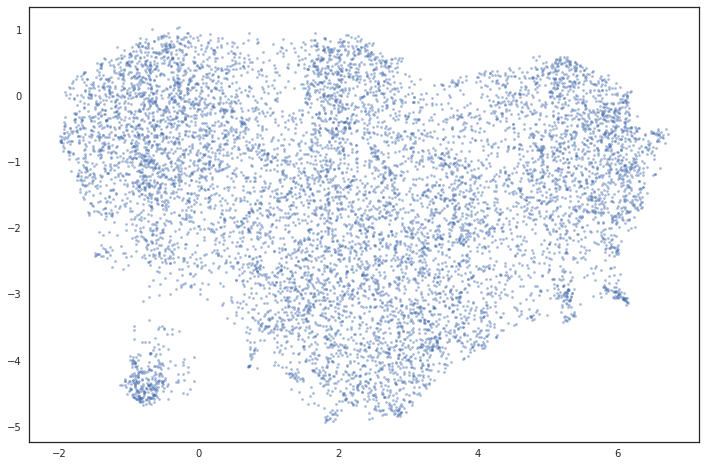

In [117]:
plot_scatter(mean_u)

### TensorBoard Embedding Projectorへ

In [134]:
import pandas as pd
limit = 5000
df = pd.DataFrame(test_ptb.data).T
test_label_list = [ids2ptext(target, test_ptb) for target in df.target.tolist()]
from torch.utils.tensorboard import SummaryWriter
log_dir = '/root/user/work/logs'
model_name = f'vae_latent16_epoch10_n={limit}'
writer = SummaryWriter(f'{log_dir}/{model_name}')
writer.add_embedding(torch.FloatTensor(encoded_mean_arr[:limit]), metadata=test_label_list[:limit])